## Linear elastic static and modal analysis of a bridge

This example is the python version of the fenicsx tutorial by Jeremy Bleyer
https://bleyerj.github.io/comet-fenicsx/tours/beams/linear_truss/linear_truss.html

In this way you can compare a native python implementation with the fenicsx one.


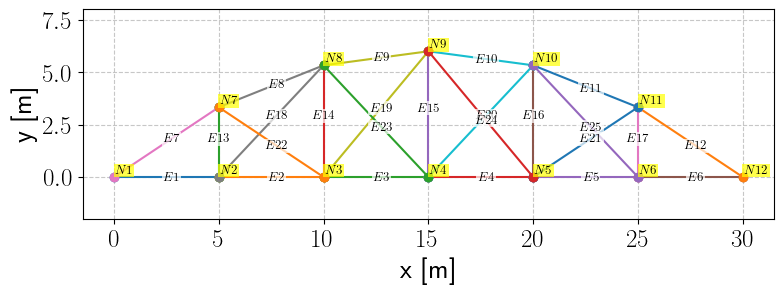

In [2]:
# As usual we start by generating the coordinates and mesh
import numpy as np
from src.postprocessing.plot_mesh import plot_truss_structure_2d
import matplotlib.pyplot as plt


# Define parameters
E = 200e3 # [Pa]
A = 1     # [m^2]
EA = E * A

l = 5.0
h1 = 3.33
h2 = 5.33
h3 = 6.0

# Node coordinates
bottom_indices = np.arange(1, 6)  
top_indices = np.arange(6, 11)

# Create coordinates matrix
n_nodes = 12
coordinates = np.zeros((n_nodes, 2))

# Assign coordinates
# Left (first node) and right (last) points
left_id = 0
right_id = 11
coordinates[left_id] = [0.0, 0.0]
coordinates[right_id] = [6*l, 0.0]

# Bottom points
for i in bottom_indices:
    coordinates[i] = [i*l, 0.0]

# Top points
for i, coord_id in enumerate(top_indices):
    h_i = [h1, h2, h3, h2, h1][i]
    coordinates[coord_id] = [(i+1)*l, h_i]


# Create connectivity table
num_bottom_lines = 6        # left + 5 bottom points + right = 7 points, 6 lines
num_top_lines = 6           # left + 5 top points + right = 7 points, 6 lines
num_vertical_lines = 5
num_diagonal_lines = 4 * 2  # 4 left diagonals + 4 right diagonals

n_elements = num_bottom_lines + num_top_lines + num_vertical_lines + num_diagonal_lines
connectivity_table = np.zeros((n_elements, 2), dtype=int)

element_id = 0 
# Bottom lines
for i in range(num_bottom_lines):
    if i == 0:
        # First bottom line connects left to first bottom point
        connectivity_table[element_id] = [left_id, bottom_indices[0]]
    elif i == num_bottom_lines - 1:
        # Last bottom line connects last bottom point to right
        connectivity_table[element_id] = [bottom_indices[-1], right_id]
    else:
        # Middle bottom lines connect adjacent bottom points
        connectivity_table[element_id] = [bottom_indices[i-1], bottom_indices[i]]
    element_id +=1

# Top lines
for i in range(num_top_lines):
    if i == 0:
        # First top line connects left to first top point
        connectivity_table[element_id] = [0, top_indices[0]]
    elif i == num_top_lines - 1:
        # Last top line connects last top point to right
        connectivity_table[element_id] = [top_indices[-1], right_id]
    else:
        # Middle top lines connect adjacent top points
        connectivity_table[element_id] = [top_indices[i-1], top_indices[i]]
    element_id +=1

# Vertical lines
for i in range(num_vertical_lines):
    connectivity_table[element_id] = [bottom_indices[i], top_indices[i]]
    element_id +=1

# Right diagonal lines (bottom to top)
for i in range(num_vertical_lines - 1):
    connectivity_table[element_id] = [bottom_indices[i], top_indices[i+1]]
    element_id +=1

# Left diagonal lines (top to bottom)
for i in range(num_vertical_lines - 1):
    connectivity_table[element_id] = [top_indices[i], bottom_indices[i+1]]
    element_id += 1

# plt.plot(coordinates[:, 0], coordinates[:, 1], 'o')
ax = plot_truss_structure_2d(coordinates, connectivity_table, 
                        xlabel='x [m]', 
                        ylabel='y [m]', 
                        ylim=[-2, 8])


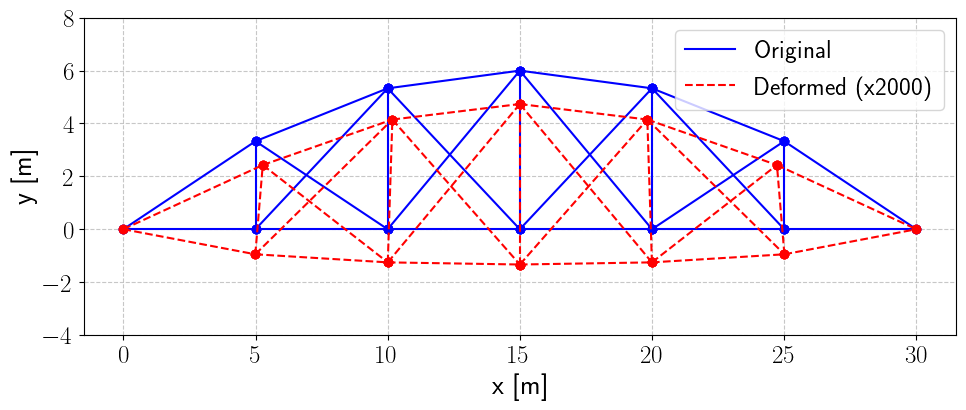

In [5]:
from src.fem.assemble_matrices import assemble_stiffness_truss_2d
from src.linear_algebra.solve_system import solve_system_homogeneous_bcs

n_dofs = n_nodes*2
f = np.zeros(n_dofs)

# Set vertical force on the vertical dofs of the bottom nodes
for i in bottom_indices:
    f[i*2+1] = -1

dofs_bcs = [2*left_id, 2*left_id+1, 2*right_id, 2*right_id+1]

K = assemble_stiffness_truss_2d(coordinates, connectivity_table, EA)
q_all, reactions = solve_system_homogeneous_bcs(K, f, dofs_bcs)

# print(f"Displacement at these nodes [m]:\n {q_all}\n")
# print(f"Reactions at bcs in [N]:\n {reactions}\n")

fig, ax = plt.subplots(figsize=(10, 8))
ax = plot_truss_structure_2d(coordinates, connectivity_table, ax=ax, 
        show_element_labels=False,
        show_node_labels=False,
        color='blue',
        linestyle='o-',
        label='Original',
        xlabel='x [m]',
        ylabel='y [m]',
        ylim=[-4, 8])

scale = 2000
deformed_coordinates = coordinates + scale * q_all.reshape(-1, 2)
ax = plot_truss_structure_2d(deformed_coordinates, connectivity_table, ax=ax, color='red',
        linestyle='o--',
        show_element_labels=False,
        show_node_labels=False,
        label=f'Deformed (x{scale})')
plt.tight_layout()
plt.show()

In [21]:
from src.fem.compute_strains_forces import compute_strains_forces_truss_2d

f_all = K @ q_all

axial_strains, axial_forces = compute_strains_forces_truss_2d(coordinates, \
                                                    connectivity_table, q_all, EA)

print(f'Minimum axial force: {np.min(axial_forces):.2f} [N]')
print(f'Maximum axial force: {np.max(axial_forces):.2f} [N]')

Minimum axial force: -4.51 [N]
Maximum axial force: 1.43 [N]
